In [1]:
'''
!pip install pyyaml
!pip install matplotlib-venn
!pip install numpy
!pip install maya
'''

'\n!pip install pyyaml\n!pip install matplotlib-venn\n!pip install numpy\n!pip install maya\n'

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
from pprint import pprint
import sqlite3
import yaml
import re
from datetime import datetime
import maya
from collections import Counter

try: # for pip >= 10
    from pip._internal.req import parse_requirements
except ImportError: # for pip <= 9.0.3
    from pip.req import parse_requirements

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

## Easier navigation:

------------------------------------

### 1. <a href='#setup'>Setup</a>
------------------------------------
### 2. <a href='#cdist'>Column distributions</a>
### 3. <a href='#merge'>Merge launches+sqlite</a>
------------------------------------
### 4. <a href='#repo'>`column`: repo</a>
### 5. <a href='#repo'>Launches - repo analysis</a>
### 6. <a href='#ti'>Timestamp Init & Difference</a>
### 7. <a href='#ni'>Next interval</a>
### 8. <a href='#tieda'>Timestamp Weekday EDA</a>
### 9. <a href='#btd'>Batched S4-8</a>
------------------------------------
### 10. <a href='#weekday'>Typical Weekday Distributions</a>
### 11. <a href='#max'>Max time difference debug</a>
### 12. <a href='#tfc'>Single PDF/CDF Time Frequency Chart</a>
### 13. <a href='#mfc'>Multiple CDF Time Frequency Chart</a>
### 14. <a href='#slfc'>Single Lookup CDF Time Frequency Chart</a>

<a name='setup'></a>
## 1. Setup

<br>

In [3]:
con = sqlite3.connect('binder-launches.db')
df = pd.read_sql('SELECT * FROM binder', con)

In [4]:
df.columns

Index(['timestamp', 'version', 'provider', 'spec', 'ref', 'origin', 'repo',
       'resolved_ref', 'org'],
      dtype='object')

In [5]:
df

,timestamp,version,provider,spec,ref,origin,repo,resolved_ref,org
0,2021-01-21T00:00:00+00:00,4,GitHub,ipython/ipython-in-depth/master,master,turing.mybinder.org,ipython/ipython-in-depth,7e5ce96cc9251083979efdfc393425f1229a4a68,ipython
1,2021-01-21T00:00:00+00:00,4,GitHub,ipython/ipython-in-depth/master,master,turing.mybinder.org,ipython/ipython-in-depth,7e5ce96cc9251083979efdfc393425f1229a4a68,ipython
2,2021-01-21T00:00:00+00:00,4,GitHub,jupyterlab/jupyterlab-demo/master,master,turing.mybinder.org,jupyterlab/jupyterlab-demo,79184a07d47cf03787b39cfc345da98794d76554,jupyterlab
3,2021-01-21T00:00:00+00:00,4,GitHub,qiskit-community/qiskit-textbook/thebe-stable,thebe-stable,turing.mybinder.org,qiskit-community/qiskit-textbook,5427cf2721cc352a522832a67845d6b59e04666b,qiskit-community
4,2021-01-21T00:00:00+00:00,4,GitHub,furnstahl/5300-notebooks/master,master,gke.mybinder.org,furnstahl/5300-notebooks,aa03b995e36957a72fee85be8d2a52aea451422a,furnstahl
...,...,...,...,...,...,...,...,...,...
13946913,2018-11-03T23:58:00+00:00,1,GitHub,ipython/ipython-in-depth/master,master,None,ipython/ipython-in-depth,,ipython
13946914,2018-11-03T23:58:00+00:00,1,GitHub,ipython/ipython-in-depth/master,master,None,ipython/ipython-in-depth,,ipython
13946915,2018-11-03T23:58:00+00:00,1,GitHub,ines/spacy-io-binder/live,live,None,ines/spacy-io-binder,,ines
13946916,2018-11-03T23:58:00+00:00,1,GitHub,ipython/ipython-in-depth/master,master,None,ipython/ipython-in-depth,,ipython


In [6]:
dash = '-' * 60

<a name='cdist'></a>
## 2. Column distributions

<br>

<AxesSubplot:xlabel='version', ylabel='count'>

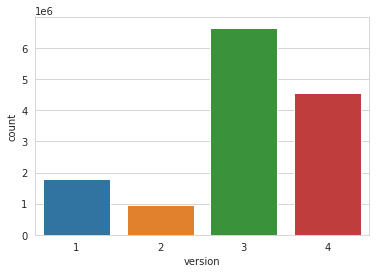

In [7]:
sns.countplot(x="version", data=df)

[Text(0, 0, 'GitHub'),
 Text(1, 0, 'Git'),
 Text(2, 0, 'Gist'),
 Text(3, 0, 'GitLab'),
 Text(4, 0, 'Zenodo'),
 Text(5, 0, 'Dataverse'),
 Text(6, 0, 'Hydroshare'),
 Text(7, 0, 'Figshare')]

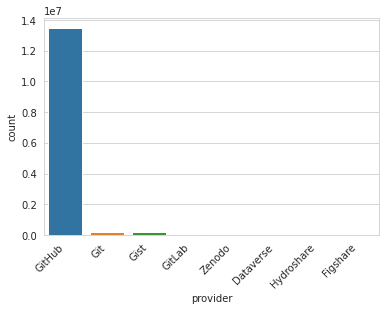

In [8]:
chart = sns.countplot(x="provider", data=df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

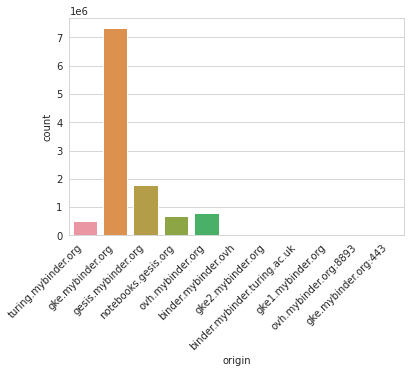

In [9]:
chart = sns.countplot(x="origin", data=df)
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

In [10]:
len(df["spec"].unique())

137685

In [11]:
len(df["repo"].unique())

112753

Since the "repo" and "ref" columns are the ones to merge with the specs dataset, it would be useful to see how many unique branches there are.

In [12]:
unique_b = len(pd.unique(df[['repo', 'ref']].values.ravel('K')))
unique_b

171770

This means that on average, each branch has about **81** entries:

In [13]:
len(df) / unique_b

81.19530767887291

<a name='merge'></a>
## 3. Merge launches+sqlite

<br>

In [14]:
'''
con = sqlite3.connect('binder-specs.sqlite')
temdf = pd.read_sql('SELECT * FROM specs', con)
merged_df = pd.merge(df, temdf,  how='inner', left_on=['repo','ref', "resolved_ref"], right_on = ['remote','git_ref', "resolved_commit"])
merged_df["repo"]
'''

'\ncon = sqlite3.connect(\'binder-specs.sqlite\')\ntemdf = pd.read_sql(\'SELECT * FROM specs\', con)\nmerged_df = pd.merge(df, temdf,  how=\'inner\', left_on=[\'repo\',\'ref\', "resolved_ref"], right_on = [\'remote\',\'git_ref\', "resolved_commit"])\nmerged_df["repo"]\n'

<a name='repo'></a>
## 4. `column`: repo

<br>

In [15]:
rp_df = df["repo"].value_counts().to_frame().reset_index()
rp_df

,index,repo
0,ipython/ipython-in-depth,4972671
1,jupyterlab/jupyterlab-demo,2573722
2,binder-examples/requirements,433068
3,ines/spacy-io-binder,335425
4,DS-100/textbook,221404
...,...,...
112747,https://jovian.ml/api/git/66fe2a3a1218447494e7...,1
112748,https://jovian.ml/api/git/748c2b22d45f438799f7...,1
112749,https://jovian.ml/api/git/5e867135e7da4ca9a67f...,1
112750,https://jovian.ml/api/git/aa8b7c128f2f438987cd...,1


x axis from 0 to 1000, log style

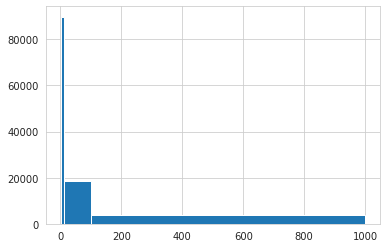

In [16]:
_ = plt.hist(rp_df["repo"], bins=(10**(np.arange(0,4))))

Same look for any set, like 100 to 10^6.

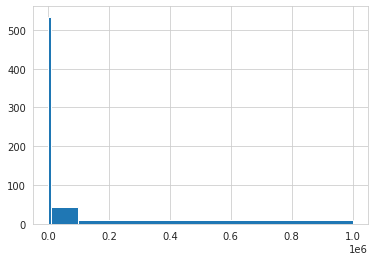

In [17]:
_ = plt.hist(rp_df["repo"], bins=(10**(np.arange(3,7))))

Frequency in each 10^x range.

In [18]:
for i in np.arange(7):
    amt = len(rp_df[(rp_df["repo"] >= (10**i))][(rp_df["repo"] < (10**(i + 1)))])
    print(str(10**i) + "-" + str(10**(i + 1)) + ": " + str(amt))
    

1-10: 89810
10-100: 18374
100-1000: 3979
1000-10000: 534
10000-100000: 44
100000-1000000: 9
1000000-10000000: 2


<a name='lra'></a>
## 5. Launches - repo analysis

<br>

A 1000+ commit repo might be interesting to look at.

In [19]:
tail_repo = rp_df[rp_df["repo"] >= 1000].iloc[-1]["index"]
tail_repo

'elyra-ai/elyra'

In [20]:
ra_df = df[df["repo"] == tail_repo]
ra_df

,timestamp,version,provider,spec,ref,origin,repo,resolved_ref,org
12883,2021-01-20T09:04:00+00:00,4,GitHub,elyra-ai/elyra/v1.5.3,v1.5.3,gke.mybinder.org,elyra-ai/elyra,9cc85f6329a8b32e089628c98f311fbcc2a9d45a,elyra-ai
18043,2021-01-20T12:37:00+00:00,4,GitHub,elyra-ai/elyra/v1.5.3,v1.5.3,gesis.mybinder.org,elyra-ai/elyra,9cc85f6329a8b32e089628c98f311fbcc2a9d45a,elyra-ai
21808,2021-01-20T14:57:00+00:00,4,GitHub,elyra-ai/elyra/v1.5.3,v1.5.3,gke.mybinder.org,elyra-ai/elyra,9cc85f6329a8b32e089628c98f311fbcc2a9d45a,elyra-ai
31422,2021-01-20T23:16:00+00:00,4,GitHub,elyra-ai/elyra/v1.5.3,v1.5.3,turing.mybinder.org,elyra-ai/elyra,9cc85f6329a8b32e089628c98f311fbcc2a9d45a,elyra-ai
31565,2021-01-20T23:29:00+00:00,4,GitHub,elyra-ai/elyra/v1.5.3,v1.5.3,turing.mybinder.org,elyra-ai/elyra,9cc85f6329a8b32e089628c98f311fbcc2a9d45a,elyra-ai
...,...,...,...,...,...,...,...,...,...
4836578,2020-06-05T16:30:00+00:00,3,GitHub,elyra-ai/elyra/master,master,gesis.mybinder.org,elyra-ai/elyra,,elyra-ai
4837758,2020-06-05T17:37:00+00:00,3,GitHub,elyra-ai/elyra/master,master,gesis.mybinder.org,elyra-ai/elyra,,elyra-ai
5594386,2020-05-03T17:44:00+00:00,3,GitHub,elyra-ai/elyra/master,master,gke.mybinder.org,elyra-ai/elyra,,elyra-ai
5833036,2020-04-23T19:43:00+00:00,3,GitHub,elyra-ai/elyra/master,master,gke.mybinder.org,elyra-ai/elyra,,elyra-ai


In [21]:
ra_df.to_pickle("./1000repo_launches.pkl")

In [22]:
ra_df = pd.read_pickle("./1000repo_launches.pkl")

<a name='ti'></a>
## 6. Timestamp init & difference

<br>

In [23]:
date_str = ra_df["timestamp"].iloc[0]
date_str

'2021-01-20T09:04:00+00:00'

In [24]:
def str2date(s):
    return maya.parse(s).datetime()

In [25]:
for i in np.arange(4, 7):
    a = datetime.now()
    cut_df = df[:10**i]
    cut_df["timestamp"].apply(lambda x: str2date(x))
    b = datetime.now()
    print("10^" + str(i) + ": " + str((b-a).seconds))

10^4: 0
10^5: 6
10^6: 61


In [26]:
dt = str2date(date_str)
print(dt)
print(dt.date())
print(dt.time())
print(dt.tzinfo)

2021-01-20 09:04:00+00:00
2021-01-20
09:04:00
UTC


Subtracting two dates

In [27]:
(str2date(ra_df["timestamp"].iloc[0]) - str2date(ra_df["timestamp"].iloc[1])).total_seconds()

-12780.0

All differences in one user

In [28]:
times = ra_df["timestamp"].apply(lambda x: str2date(x)).sort_values(ascending=False)
times

31565     2021-01-20 23:29:00+00:00
31422     2021-01-20 23:16:00+00:00
21808     2021-01-20 14:57:00+00:00
18043     2021-01-20 12:37:00+00:00
12883     2021-01-20 09:04:00+00:00
                     ...           
4837758   2020-06-05 17:37:00+00:00
4836578   2020-06-05 16:30:00+00:00
5594386   2020-05-03 17:44:00+00:00
5833036   2020-04-23 19:43:00+00:00
6661333   2020-03-18 17:23:00+00:00
Name: timestamp, Length: 1000, dtype: datetime64[ns, UTC]

In [29]:
time_diff = []
time_total = []
prev = 0
for i in times:
    if prev != 0:
        if (i - prev).seconds != 0:
            time_diff.append((prev - i).total_seconds())
            if time_total != []:
                time_total.append(time_total[-1] + time_diff[-1])
            else:
                time_total.append(time_diff[-1])
    prev = i
time_diff[0:10], time_total[0:10]

([780.0,
  29940.0,
  8400.0,
  12780.0,
  66180.0,
  13680.0,
  4440.0,
  19200.0,
  18420.0,
  107760.0],
 [780.0,
  30720.0,
  39120.0,
  51900.0,
  118080.0,
  131760.0,
  136200.0,
  155400.0,
  173820.0,
  281580.0])

Plotting within 2 SDs.

In [30]:
h=sorted(time_diff)
out_threshold= 2.0 * np.std(h + [-a for a in h])
h=[i for i in h if i < out_threshold]

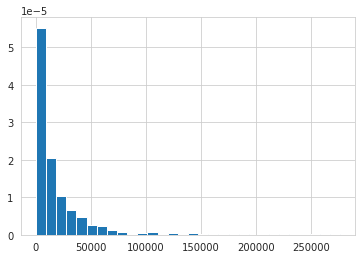

In [31]:
_ = plt.hist(h, density=True, bins=30)

In [32]:
xax = np.arange(0, len(time_diff)).tolist()

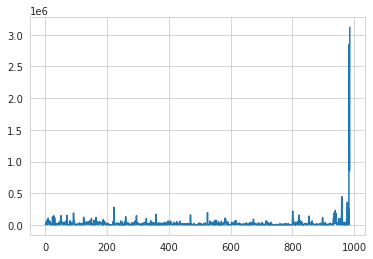

In [33]:
plt.plot(xax, time_diff)

<AxesSubplot:>

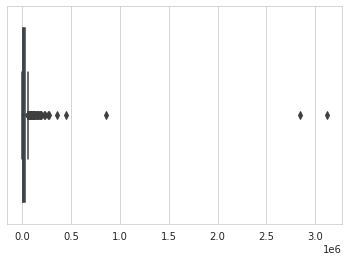

In [34]:
sns.boxplot(time_diff)

<a name='ni'></a>
## 7. Next interval

<br>

In [35]:
for i in np.arange(4):
    amt = len(list(filter(lambda x: x > 20000 * i and x < 20000 * (i+1), time_diff)))
    print(str(20000 * i) + "-" + str(20000 * (i+1)) + ": " + str(amt))

0-20000: 706
20000-40000: 153
40000-60000: 55
60000-80000: 28


<AxesSubplot:>

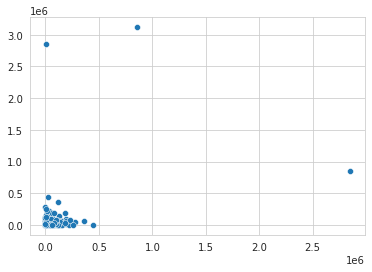

In [36]:
before_t = time_diff[:-1]
after_t = time_diff[1:]
sns.scatterplot(before_t, after_t)

<a name='tieda'></a>
## 8. Timestamp Weekday/Day/Month EDA

<br>

0 is for Monday and 6 is for Sunday.

In [37]:
(str2date(ra_df["timestamp"].iloc[0])).weekday()

2

In [38]:
times.iloc[0].weekday()

2

In [39]:
weekday = times.apply(lambda x: x.weekday()).tolist()

<AxesSubplot:ylabel='count'>

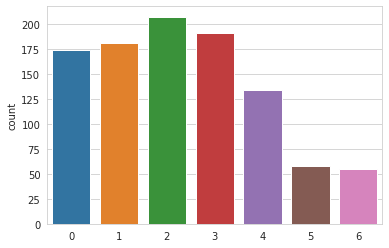

In [40]:
sns.countplot(weekday)

In [41]:
month = times.apply(lambda x: x.month).tolist()

<AxesSubplot:ylabel='count'>

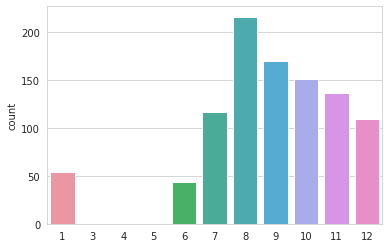

In [42]:
sns.countplot(month)

In [43]:
days = times.apply(lambda x: x.day).tolist()

<AxesSubplot:ylabel='count'>

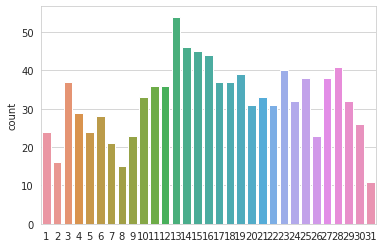

In [44]:
sns.countplot(days)

<a name='btd'></a>
## 9. Batched S5-8

<br>

uber/deck.gl
0.0-20000.0: 1947
20000.0-40000.0: 435
40000.0-60000.0: 154
60000.0-80000.0: 82
80000.0-100000.0: 28
100000.0-120000.0: 10
120000.0-140000.0: 6
140000.0-160000.0: 3
160000.0-180000.0: 4
180000.0-200000.0: 2
200000.0-220000.0: 1
220000.0-240000.0: 2
240000.0-260000.0: 0
260000.0-280000.0: 1
280000.0-300000.0: 0
300000.0-320000.0: 0
320000.0-340000.0: 2
340000.0-360000.0: 0
360000.0-380000.0: 0
380000.0-400000.0: 0
400000.0-420000.0: 0
420000.0-440000.0: 1
440000.0-460000.0: 0
460000.0-480000.0: 0
480000.0-500000.0: 0
500000.0-520000.0: 0
520000.0-540000.0: 1
540000.0-560000.0: 0
560000.0-580000.0: 0
580000.0-600000.0: 1
600000.0-620000.0: 0
620000.0-640000.0: 0
640000.0-660000.0: 0
660000.0-680000.0: 0
680000.0-700000.0: 0
700000.0-720000.0: 0
720000.0-740000.0: 0
740000.0-760000.0: 0
760000.0-780000.0: 0
780000.0-800000.0: 1
800000.0-820000.0: 0
820000.0-840000.0: 0
840000.0-860000.0: 0
860000.0-880000.0: 0
880000.0-900000.0: 0
900000.0-920000.0: 0
920000.0-940000.0: 0
940

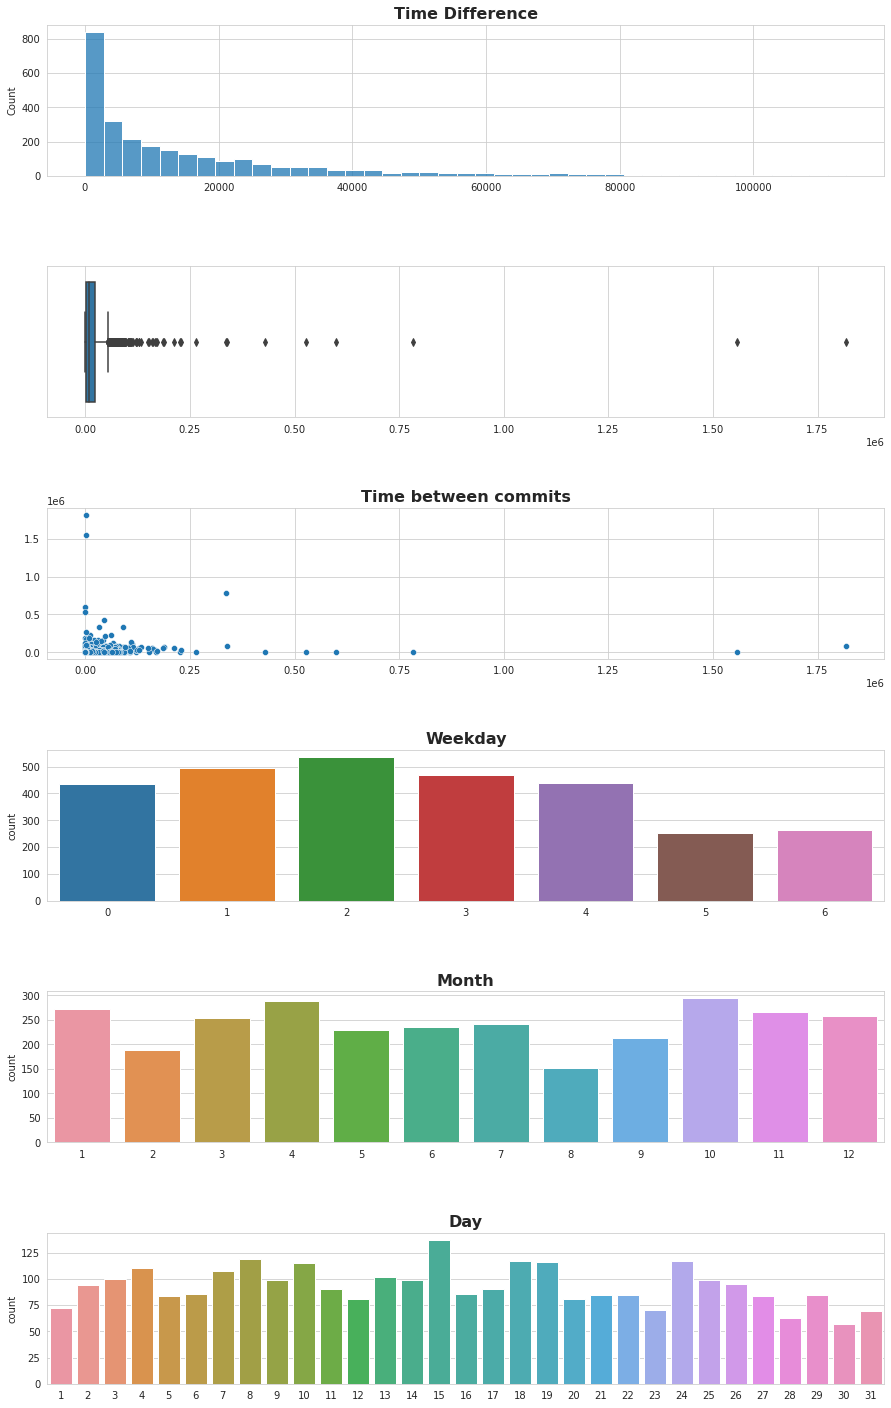

In [45]:
def str2date(s):
    return maya.parse(s).datetime()

def batch(min_count, max_count, index):
    
    fig, axs = plt.subplots(6, 1, figsize=(15,25))
    plt.subplots_adjust(hspace=0.6)
    
    #5
    tail_repo = rp_df[rp_df["repo"] >= min_count][rp_df["repo"] <= max_count].iloc[index]["index"]
    print(tail_repo)
    ra_df = df[df["repo"] == tail_repo]
    
    times = ra_df["timestamp"].apply(lambda x: str2date(x)).sort_values(ascending=False)
    time_diff = []
    prev = 0
    for i in times:
        if prev != 0:
            if (i - prev).seconds != 0:
                time_diff.append((prev - i).total_seconds())
        prev = i
    
    h=sorted(time_diff)
    out_threshold= 2.0 * np.std(h + [-a for a in h])
    h=[i for i in h if i < out_threshold]
    sns.histplot(h, ax=axs[0]).set_title("Time Difference", fontdict= { 'fontsize': 16, 'fontweight':'bold'})
    
    xax = np.arange(0, len(time_diff)).tolist()
    sns.boxplot(time_diff, ax=axs[1])
    
    max_amt = max(time_diff) // 20000
    for i in np.arange(max_amt + 1):
        amt = len(list(filter(lambda x: x > 20000 * i and x < 20000 * (i+1), time_diff)))
        print(str(20000 * i) + "-" + str(20000 * (i+1)) + ": " + str(amt))
        
    before_t = time_diff[:-1]
    after_t = time_diff[1:]
    sns.scatterplot(before_t, after_t, ax=axs[2]).set_title("Time between commits", fontdict= { 'fontsize': 16, 'fontweight':'bold'})
    
    #8
    weekday = times.apply(lambda x: x.weekday()).tolist()
    sns.countplot(weekday, ax=axs[3]).set_title("Weekday", fontdict= { 'fontsize': 16, 'fontweight':'bold'})
    
    month = times.apply(lambda x: x.month).tolist()
    sns.countplot(month, ax=axs[4]).set_title("Month", fontdict= { 'fontsize': 16, 'fontweight':'bold'})
    
    days = times.apply(lambda x: x.day).tolist()
    sns.countplot(days, ax=axs[5]).set_title("Day", fontdict= { 'fontsize': 16, 'fontweight':'bold'})
    
batch(2000, 3001, 10)

<a name='weekday'></a>
## 10. Typical Weekday Distributions

<br>

In [46]:
def weekday_dist(min_count, max_count, low, high):
    ret_list = []
    for i in np.arange(low, high):
        tail_repo = rp_df[rp_df["repo"] >= min_count][rp_df["repo"] <= max_count].iloc[i]["index"]
        #print(tail_repo)
        ra_df = df[df["repo"] == tail_repo]
        times = ra_df["timestamp"].apply(lambda x: str2date(x)).sort_values(ascending=False)
        weekday = times.apply(lambda x: x.weekday()).tolist()
        ret_list.append(Counter(weekday).most_common()[0][1] / len(weekday))
    return ret_list
        
weekdays = weekday_dist(1000, 2000, 0, 30)

In [47]:
weekdays

[0.1925,
 0.2700656234225139,
 0.32979261507334345,
 0.17924050632911392,
 0.6063991874047739,
 0.1794871794871795,
 0.2391304347826087,
 0.19430051813471502,
 0.5192307692307693,
 0.1919875130072841,
 0.22170057381324987,
 0.1722338204592902,
 0.1546932354483482,
 0.5669291338582677,
 0.165520888418826,
 0.2409957627118644,
 0.24628450106157113,
 0.31206804891015416,
 0.16737967914438504,
 0.1839572192513369,
 0.16335303600214937,
 0.3240043057050592,
 0.31351351351351353,
 0.29621621621621624,
 0.1654054054054054,
 0.2159090909090909,
 0.5184182015167931,
 0.15572436245252305,
 0.8458197611292074,
 0.17816404128191202]

<AxesSubplot:ylabel='Count'>

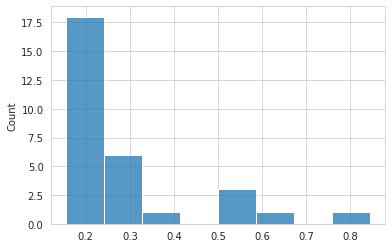

In [48]:
sns.histplot(weekdays)

<a name='max'></a>
## 11. Max time difference debug

<br>

In the scatterplots above, the maximum time difference is always capped at roughly ~86,000. Checking to see if this is really the case

In [49]:
def max_diff(min_count, max_count, low, high):
    ret_list = []
    for i in np.arange(low, high):
        tail_repo = rp_df[rp_df["repo"] >= min_count][rp_df["repo"] <= max_count].iloc[i]["index"]
        #print(tail_repo)
        ra_df = df[df["repo"] == tail_repo]
        times = ra_df["timestamp"].apply(lambda x: str2date(x)).sort_values(ascending=False)
        time_diff = []
        prev = 0
        for i in times:
            if prev != 0:
                if (i - prev).seconds != 0:
                    time_diff.append((i - prev).seconds)
            prev = i
        ret_list.append(max(time_diff))
    return ret_list
        
max_diffs = max_diff(1000, 2000, 0, 10)

In [50]:
max_diffs

[86340, 86340, 86340, 86340, 86340, 86340, 86340, 86340, 86340, 86340]

In [51]:
time_diff_s = []
time_diff_ts = []
prev = 0
for i in times:
    if prev != 0:
        if (i - prev).seconds != 0:
            time_diff_ts.append((prev - i).total_seconds())
            time_diff_s.append((i - prev).seconds)
    prev = i
time_diff_ts[0:10], time_diff_s[0:10]

([780.0,
  29940.0,
  8400.0,
  12780.0,
  66180.0,
  13680.0,
  4440.0,
  19200.0,
  18420.0,
  107760.0],
 [85620, 56460, 78000, 73620, 20220, 72720, 81960, 67200, 67980, 65040])

<a name='tfc'></a>
## 12. Single PDF/CDF Time Frequency Chart

<br>

In [52]:
test_x = [times.iloc[0].date(), times.iloc[1].date(), times.iloc[4].date()] 
test_y = [4, 9, 7]

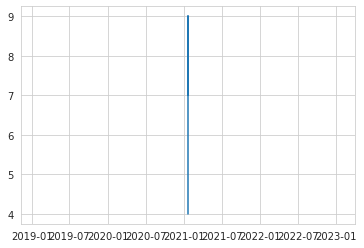

In [53]:
plt.plot(test_x, test_y)

In [54]:
xseries = times.apply(lambda x: x.date()).value_counts()
xtime = xseries.index.tolist()
ytime = xseries.values.tolist()
time_df = pd.DataFrame()
time_df["Date"] = xtime
time_df["Frequency"] = ytime
time_df = time_df.sort_values("Date")
time_df["Cumulative"] = time_df["Frequency"].cumsum()
time_df

,Date,Frequency,Cumulative
173,2020-03-18,1,1
172,2020-04-23,1,2
188,2020-05-03,1,3
138,2020-06-05,2,5
107,2020-06-08,3,8
...,...,...,...
116,2021-01-16,3,988
142,2021-01-17,2,990
184,2021-01-18,1,991
105,2021-01-19,4,995


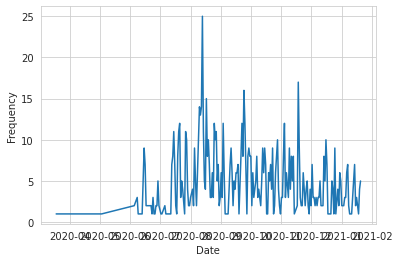

In [55]:
chart1 = sns.lineplot(x="Date", y="Frequency", data=time_df)

<AxesSubplot:xlabel='Date', ylabel='Cumulative'>

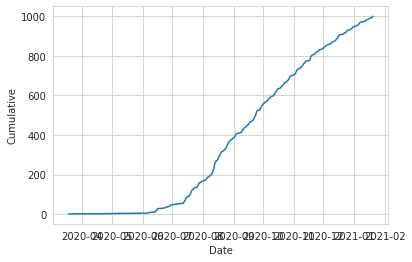

In [56]:
sns.lineplot(x="Date", y="Cumulative", data=time_df)

In order to align multiple charts, we need an x-axis that fits all. Using days since first binder launch makes most sense.

In [57]:
time_df["Days Passed"] = (time_df["Date"] - time_df["Date"].iloc[0]).apply(lambda x: float(str(x).split(" ")[0]))
time_df

,Date,Frequency,Cumulative,Days Passed
173,2020-03-18,1,1,0.0
172,2020-04-23,1,2,36.0
188,2020-05-03,1,3,46.0
138,2020-06-05,2,5,79.0
107,2020-06-08,3,8,82.0
...,...,...,...,...
116,2021-01-16,3,988,304.0
142,2021-01-17,2,990,305.0
184,2021-01-18,1,991,306.0
105,2021-01-19,4,995,307.0


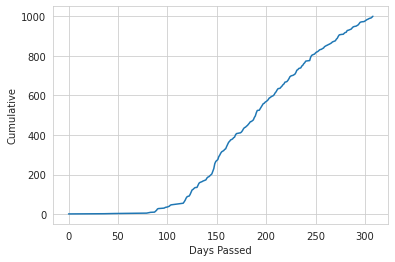

In [58]:
chart = sns.lineplot(x="Days Passed", y="Cumulative", data=time_df)

<a name='mfc'></a>
## 13. Multiple CDF Time Frequency Chart

<br>

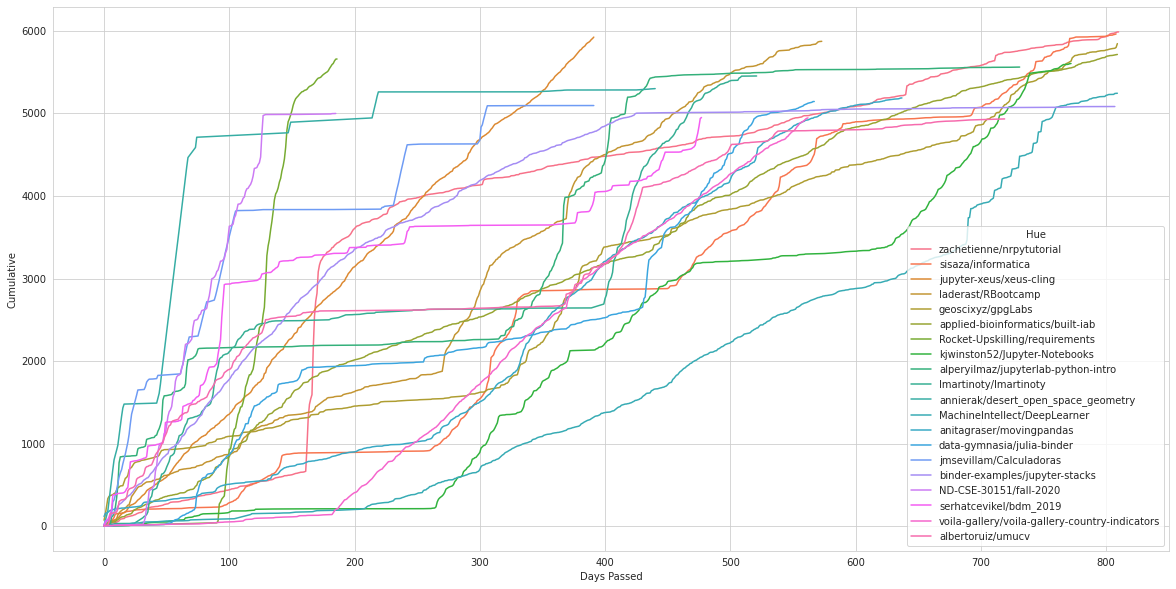

In [59]:
def cdf_frequency(min_count, max_count, low, high):
    
    full_time_df = pd.DataFrame()
    for i in np.arange(low, high):
        #5
        tail_repo = rp_df[rp_df["repo"] >= min_count][rp_df["repo"] <= max_count].iloc[i]["index"]
        #print(tail_repo)
        ra_df = df[df["repo"] == tail_repo]
        times = ra_df["timestamp"].apply(lambda x: str2date(x)).sort_values(ascending=False)
        
        
        # 12
        xseries = times.apply(lambda x: x.date()).value_counts()
        xtime = xseries.index.tolist()
        ytime = xseries.values.tolist()
        time_df = pd.DataFrame()
        time_df["Date"] = xtime
        time_df["Frequency"] = ytime
        time_df = time_df.sort_values("Date")
        time_df["Cumulative"] = time_df["Frequency"].cumsum()
        time_df["Days Passed"] = (time_df["Date"] - time_df["Date"].iloc[0]).apply(lambda x: float(str(x).split(" ")[0]))
        time_df["Hue"] = tail_repo
        
        full_time_df = full_time_df.append(time_df)
    
    plot1 = plt.figure(figsize=(20,10))
    chart = sns.lineplot(x="Days Passed", y="Cumulative", data=full_time_df, hue="Hue")
        
    return full_time_df
    
tdf = cdf_frequency(2000, 6001, 0, 20)

<a name='slfc'></a>
## 14. Single Lookup CDF Time Frequency Chart

<br>

In [80]:
lookup_rp_df = rp_df[rp_df["index"].str.contains("parsl")]
lookup_rp_df

,index,repo
340,Parsl/parsl-tutorial,1816
56869,parsl/parsl-tutorial,2


In [78]:
times["index"]

7469       2021-01-20 04:23:00+00:00
59737      2021-01-18 01:37:00+00:00
109199     2021-01-16 14:16:00+00:00
108037     2021-01-16 12:45:00+00:00
101184     2021-01-16 00:29:00+00:00
                      ...           
13886848   2018-11-08 16:07:00+00:00
13915577   2018-11-06 18:44:00+00:00
13909132   2018-11-06 09:31:00+00:00
13923372   2018-11-05 10:01:00+00:00
13935255   2018-11-04 11:55:00+00:00
Name: timestamp, Length: 1816, dtype: datetime64[ns, UTC]

In [83]:
#print(tail_repo)
ra_df = df[df["repo"] == lookup_rp_df.iloc[0]["index"]]
times = ra_df["timestamp"].apply(lambda x: str2date(x)).sort_values(ascending=False)


# 12

xseries = times.apply(lambda x: x.date()).value_counts()
xtime = xseries.index.tolist()
ytime = xseries.values.tolist()
time_df = pd.DataFrame()
time_df["Date"] = xtime
time_df["Frequency"] = ytime
time_df = time_df.sort_values("Date")
time_df["Cumulative"] = time_df["Frequency"].cumsum()
time_df["Days Passed"] = (time_df["Date"] - time_df["Date"].iloc[0]).apply(lambda x: float(str(x).split(" ")[0]))
time_df["Hue"] = lookup_rp_df.iloc[0]["index"]


time_df

,Date,Frequency,Cumulative,Days Passed,Hue
440,2018-11-04,1,1,0.0,Parsl/parsl-tutorial
488,2018-11-05,1,2,1.0,Parsl/parsl-tutorial
375,2018-11-06,2,4,2.0,Parsl/parsl-tutorial
515,2018-11-08,1,5,4.0,Parsl/parsl-tutorial
231,2018-11-09,3,8,5.0,Parsl/parsl-tutorial
...,...,...,...,...,...
87,2021-01-14,5,1810,802.0,Parsl/parsl-tutorial
531,2021-01-15,1,1811,803.0,Parsl/parsl-tutorial
206,2021-01-16,3,1814,804.0,Parsl/parsl-tutorial
465,2021-01-18,1,1815,806.0,Parsl/parsl-tutorial


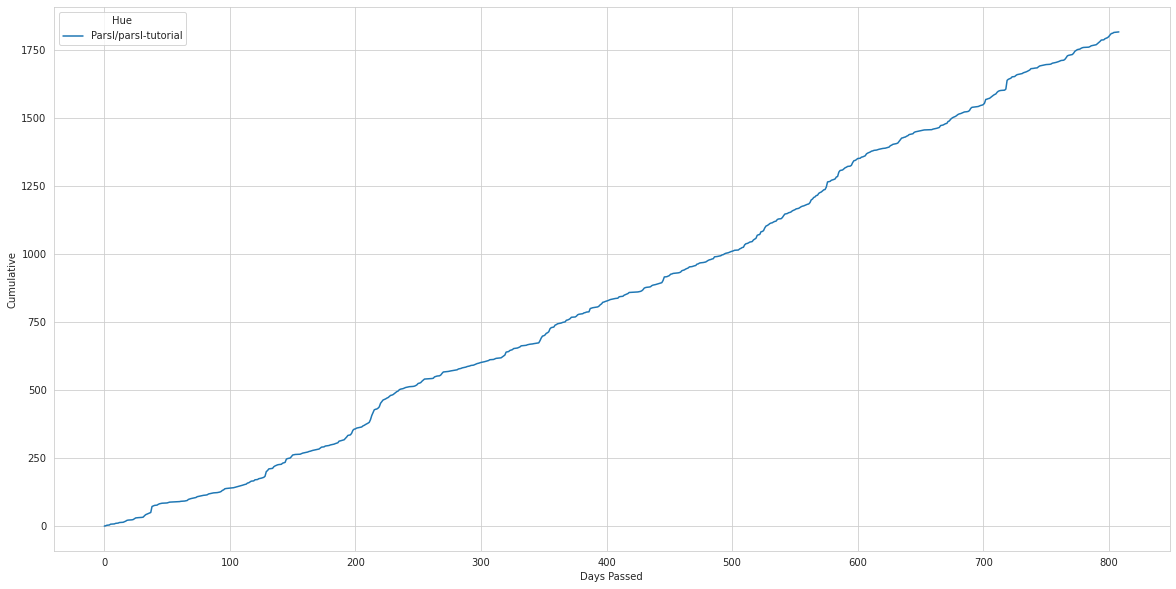

In [84]:
plot1 = plt.figure(figsize=(20,10))
chart = sns.lineplot(x="Days Passed", y="Cumulative", data=time_df, hue="Hue")

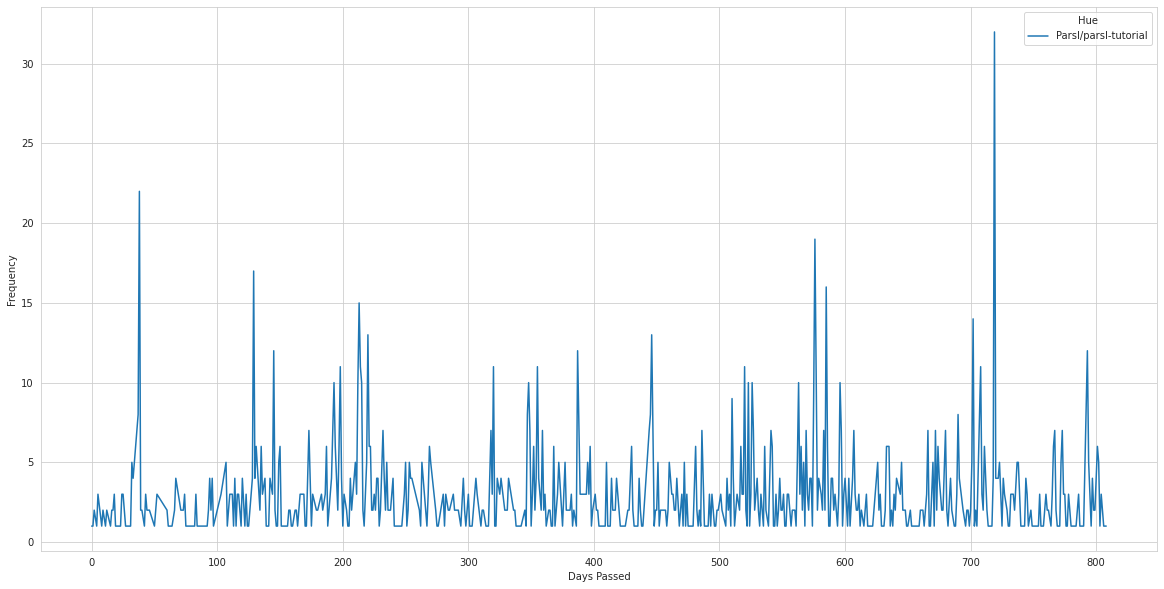

In [85]:
plot1 = plt.figure(figsize=(20,10))
chart = sns.lineplot(x="Days Passed", y="Frequency", data=time_df, hue="Hue")